# Align four or more semi-simultaneously recorded audio recordings. Designed for radio mics.
## - We will align the signals on just a small (5 second) chunk
## - We will use a smoothed rectified (~amplitude) signal, and use cross correlation to calculation the offsets
## - We will align to the loudest signal.

In [1]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
import os
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
# from soundsig.sound import BioSound 
# from soundsig.sound import WavFile

# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


### Use Raven or some other spectrogram program to find a spot that you can align all four recordings too. 
### Then open each file around that area, align them, and save the offsets. 

### Enter your file paths and times to delineate the area to align

In [2]:
# data_path = '/Users/williamwood/Documents/Sound_Localization/July_Recordings/audio_recordings/'
data_path = '/Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup'


In [3]:
# You may want to play with these parameters, particularly the length of the chunk
align_length = 0.5 # the length of our chunk, in seconds
lowpass_thresh = 200 # the frequency below which we will lowpass filter the signal
highpass_thresh = 4000 # the frequency above which we will highpass filter the signal


# Update the values in this cell!


In [4]:
# starting_minutes = "46" # the minute of the recording where we want to start looking for the alignment point
# starting_seconds = "30" # the second of the recording where we want to start looking for the alignment point
num_to_align = 3 # the number of recordings we want to align

rec_1 = {
    "file_name": "audio_423215500Hz_11-18-36_22-12-2023.wav", #"audio_442360000Hz_09-29-44_18-07-2023.wav",
    "rough_align_minute": "68", # in minutes
    "rough_align_second": "35.5", # in seconds
    "subject_name": "RedTap0000M",
}
rec_2 = {
    "file_name": "audio_432740000Hz_11-18-40_22-12-2023.wav", #"audio_458185540Hz_09-29-42_18-07-2023.wav",
    "rough_align_minute": "68", # in minutes 
    "rough_align_second": "31.5", # in seconds
    "subject_name": "WhiTap0000F", 
}
rec_3 = {
    "file_name": "audio_458181000Hz_11-19-34_22-12-2023.wav", #"audio_423212900Hz_09-29-54_18-07-2023.wav",
    "rough_align_minute": "67", # in minutes
    "rough_align_second": "36.8", # in seconds
    "subject_name": "WhiWhi1541M",
}
# rec_4 = {
#     "file_name": "audio_458185540Hz_14-37-58_18-07-2023.wav", #"audio_432736430Hz_09-29-58_18-07-2023.wav",
#     "rough_align_minute": "46", # in minutes
#     "rough_align_second": "30.8", # in seconds
#     "subject_name": "WhiWhi6607F",
# }

# put em in a list to iterate over later
if num_to_align == 3:
    rec_dict_list = [rec_1, rec_2, rec_3]   
elif num_to_align == 4:
    rec_dict_list = [rec_1, rec_2, rec_3, rec_4]




In [5]:
# offset_list = [
#     -6.0,
#     -8,
#     -2,
#     0]
# #this is particular to one recording and you won't want to use it again
# # add two seconds to every rough_align_second  
# for i, rec in enumerate(rec_dict_list):
#     rec["rough_align_second"] = float(rec["rough_align_second"]) + offset_list[i]
#     print(rec["rough_align_second"])

In [6]:
# # I would like to only load the portion of the wav file we are interested in (lazy loading- the chunk we want to align)
# # We will need a libary to do this

# # We will need a function to do this
# def load_wav_chunk(file_name, rough_align_minute, rough_align_second, align_length):


In [7]:
#load the data, filter it, normalize it, and store it in the dictionary
for i, dict_item in enumerate(rec_dict_list):
    print(f'opening data file:{os.path.join(data_path, dict_item["file_name"])}')
    fs, data_wav = read(os.path.join(data_path, dict_item["file_name"]))

    if data_wav.ndim > 1:
        data_wav = data_wav[:,0] # just take the first channel, typically the second is empty or identical - not every file has two channels so this may error
    else:
        pass
    print(f'Normalizing data...')
    # save an unfiltered version of the data
    rec_dict_list[i]["data_wav_unfiltered"] = data_wav
    
    data_wav = data_wav / np.max(np.abs(data_wav))
    print(f'Filtering data...')
    sos = butter(10, [lowpass_thresh, highpass_thresh], 'bandpass', fs=fs, output='sos')
    data_wav = sosfiltfilt(sos, data_wav)
    rec_dict_list[i]["fs"] = fs
    rec_dict_list[i]["data_wav"] = data_wav
    rec_dict_list[i]["data_wav_len"] = len(data_wav)
    rec_dict_list[i]["data_wav_len_minutes"] = len(data_wav)/fs/60
    rec_dict_list[i]["rough_align_point"] = int(float(dict_item["rough_align_minute"]) * 60 * fs + float(dict_item["rough_align_second"]) * fs)
    rec_dict_list[i]["rough_align_time"] = float(dict_item["rough_align_minute"]) * 60 + float(dict_item["rough_align_second"])
    print(f'fs: {fs}, data_wav_len: {len(data_wav)/fs/60} minutes')


print(f'Done loading data files. \n\n')
print(f'Example dictionary item: {rec_dict_list[0]}')


opening data file:/Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/audio_423215500Hz_11-18-36_22-12-2023.wav
Normalizing data...
Filtering data...
fs: 44100, data_wav_len: 168.36462055933487 minutes
opening data file:/Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/audio_432740000Hz_11-18-40_22-12-2023.wav
Normalizing data...
Filtering data...
fs: 44100, data_wav_len: 168.3907894935752 minutes
opening data file:/Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/audio_458181000Hz_11-19-34_22-12-2023.wav
Normalizing data...
Filtering data...
fs: 44100, data_wav_len: 167.4378329554044 minutes
Done loading data files. 


Example dictionary item: {'file_name': 'audio_423215500Hz_11-18-36_22-12-2023.wav', 'rough_align_m

plotting spectrogram for audio_423215500Hz_11-18-36_22-12-2023.wav, starting at 4115.5 seconds and 181493550 samples


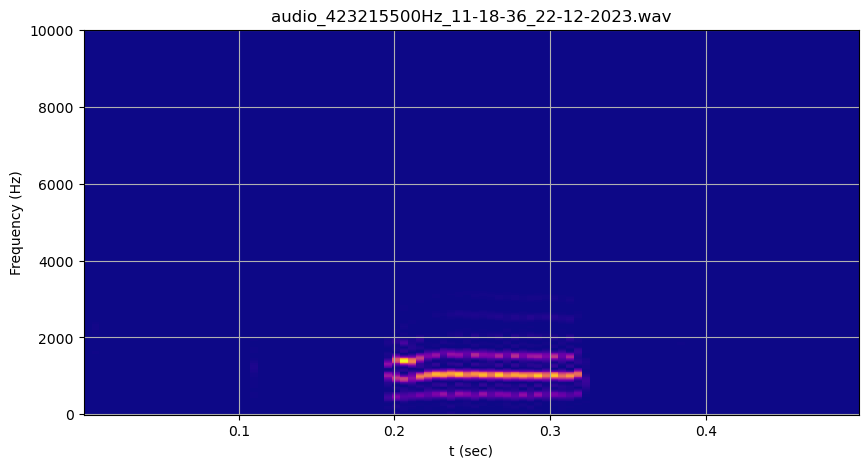

plotting spectrogram for audio_432740000Hz_11-18-40_22-12-2023.wav, starting at 4111.5 seconds and 181317150 samples


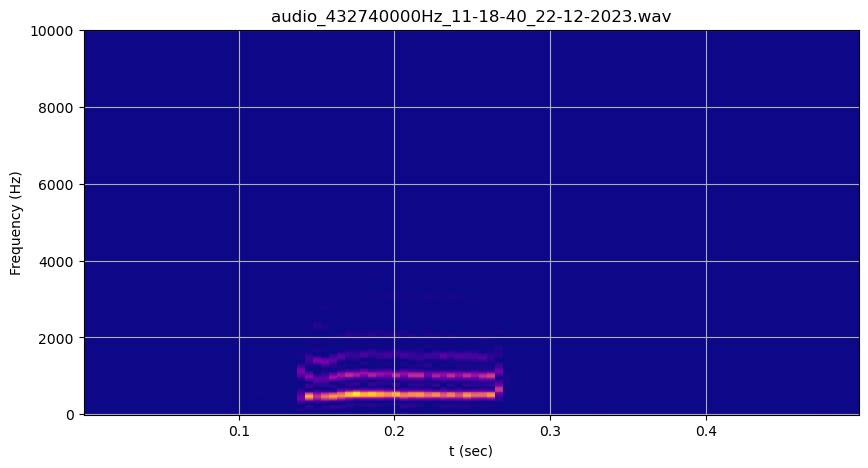

plotting spectrogram for audio_458181000Hz_11-19-34_22-12-2023.wav, starting at 4056.8 seconds and 178904880 samples


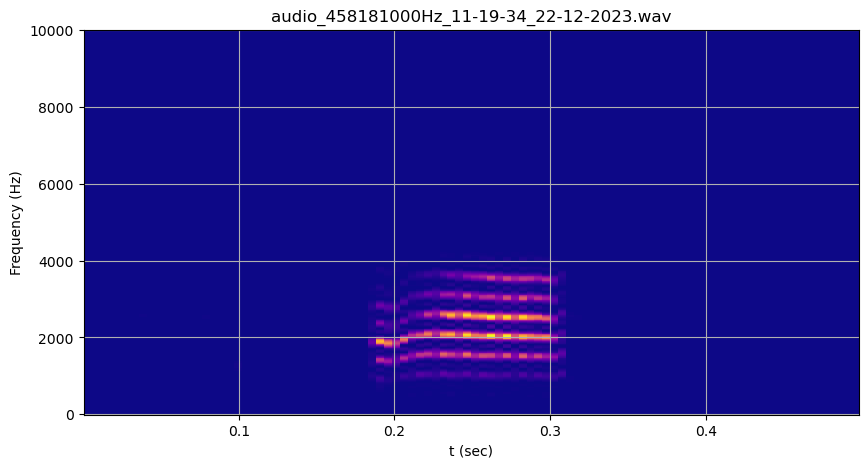

In [8]:
#iterate over the list of dictionaries and plot the spectrogram around the rough alignment time
# just to verify that the rough alignment time is good
for i, dict_item in enumerate(rec_dict_list):
    print(f'plotting spectrogram for {dict_item["file_name"]}, starting at {dict_item["rough_align_time"]} seconds and {dict_item["rough_align_point"]} samples')
    # print(f'starting point is {dict_item["rough_align_time"]*dict_item["fs"]} samples')
    # print(f'in samples, other calc: {dict_item["rough_align_point"]}')
    plot_a_spectrogram(dict_item["data_wav"][dict_item["rough_align_point"]:dict_item["rough_align_point"]+int(align_length*dict_item["fs"])], fs = dict_item["fs"], title=dict_item["file_name"])
    plt.show()

In [9]:
# #iterate over the list of dictionaries and plot the spectrogram around the rough alignment time
# # just to verify that the rough alignment time is good
# for i, dict_item in enumerate(rec_dict_list):
#     print(f'plotting spectrogram for {dict_item["file_name"]}, starting at {dict_item["rough_align_time"]} seconds')
#     print(f'starting point is {dict_item["rough_align_time"]*dict_item["fs"]} samples')
#     plot_a_spectrogram(dict_item["data_wav"][int(float(dict_item["rough_align_time"])*dict_item["fs"]):int(float(dict_item["rough_align_time"])*dict_item["fs"])+int(align_length*dict_item["fs"])], fs = dict_item["fs"], title=dict_item["file_name"])
#     plt.show()


# If those spectrograms appear to show approximately the same chunk of time we can use cross-correlation
# to more exactly align the files

In [10]:
# I put chunks in a list and iterate over them later

chunk_list = list()
for i, dict_item in enumerate(rec_dict_list):
    chunk_to_align = dict_item["data_wav"][dict_item["rough_align_point"]:dict_item["rough_align_point"]+int(align_length*dict_item["fs"])]
    chunk_list.append(chunk_to_align)


# We are going to rectify and smooth the data that will be correlated. This amplitude envelope gives more robust alignments

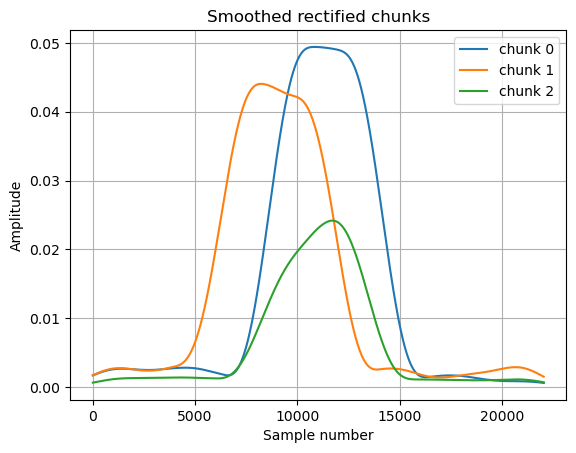

loudest signal index: 0


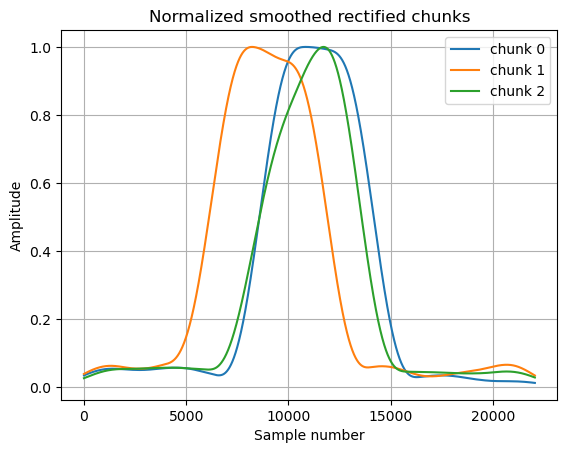

In [11]:
smoothed_chunk_list = list()
# function for smoothing and rectifying a signal
def smooth(x, window_len=round(fs*.1), window='hanning'):
    return np.convolve(np.sqrt(x*x), eval('np.'+window+'(window_len)'), mode='same') / sum(eval('np.'+window+'(window_len)'))

# smooth and rectify the signal (this is the same as the amplitude envelope)
for chunk in chunk_list:
    smoothed_chunk = smooth(chunk)
    smoothed_chunk_list.append(smoothed_chunk)
    
# plot the amplitude envelopes of each chunk on top of each other
for chunk in smoothed_chunk_list:
    plt.plot(chunk)
plt.title('Smoothed rectified chunks')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.grid()
plt.legend([f'chunk {i}' for i in range(len(smoothed_chunk_list))])
plt.show()

amps = [np.mean(smoothed_chunk_list[i]) for i in range(len(smoothed_chunk_list))]
loudest_signal_index = np.argmax(amps)
print(f'loudest signal index: {loudest_signal_index}')


# Now normalize the amplitudes of the smoothed rectified signals
# by dividing by the max amplitude of each signal
for i, chunk in enumerate(smoothed_chunk_list):
    smoothed_chunk_list[i] = chunk / np.max(chunk)

# plot the normalized smoothed rectified signal of each chunk on top of each other
for chunk in smoothed_chunk_list:
    plt.plot(chunk)
plt.title('Normalized smoothed rectified chunks')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.grid()
plt.legend([f'chunk {i}' for i in range(len(smoothed_chunk_list))])
plt.show()


In [12]:
# Align the smoothed rectified signals
# iterate over the smoothed chunks and use cross correlation to find the offset between all signals, pairwise
offset_alignment_array = np.zeros((len(rec_dict_list), len(rec_dict_list)))
offset_strength_array = np.zeros((len(rec_dict_list), len(rec_dict_list)))
for i, dict_item in enumerate(rec_dict_list):
    chunk_to_align = smoothed_chunk_list[i]
    for j, dict_item_2 in enumerate(rec_dict_list):
        chunk_to_align_2 = smoothed_chunk_list[j]
        if i != j:
            cross_corr = correlate(chunk_to_align, chunk_to_align_2)   
            offset = np.argmax(cross_corr) - len(chunk_to_align)
            offset_strength = np.max(cross_corr)
            # print(f'offset between {dict_item["file_name"]} and {dict_item_2["file_name"]}: {offset}')
            # print(f'offset strength: {offset_strength}')
            offset_alignment_array[i,j] = offset
            offset_strength_array[i,j] = offset_strength
        else:
            # print(f'offset between {dict_item["file_name"]} and {dict_item_2["file_name"]}: 0')
            offset_alignment_array[i,j] = np.nan
            offset_strength_array[i,j] = np.nan


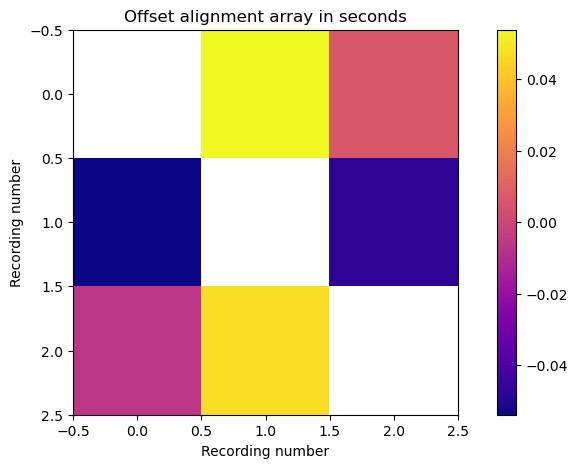

In [13]:
# plot the alignment array
offset_alignment_array_in_seconds = offset_alignment_array / fs
plt.figure(figsize=(10, 5))
plt.imshow(offset_alignment_array_in_seconds, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Offset alignment array in seconds')
plt.xlabel('Recording number')
plt.ylabel('Recording number')
plt.show()

## I had a bug where the alignemnts were in the wrong units, so I made this plot to check
# # plot the alignment array
# offset_alignment_array = offset_alignment_array
# plt.figure(figsize=(10, 5))
# plt.imshow(offset_alignment_array, cmap='plasma', interpolation='nearest')
# plt.colorbar()
# plt.title('Offset alignment array in data points')
# plt.xlabel('Recording number')
# plt.ylabel('Recording number')
# plt.show()


offset between audio_423215500Hz_11-18-36_22-12-2023.wav and loudest signal: nan
offset between audio_432740000Hz_11-18-40_22-12-2023.wav and loudest signal: 2374.0
offset between audio_458181000Hz_11-19-34_22-12-2023.wav and loudest signal: 283.0
not padding audio_423215500Hz_11-18-36_22-12-2023.wav, i=0, loudest_signal_index=0
padding audio_432740000Hz_11-18-40_22-12-2023.wav with 2374.0 zeros
padding audio_458181000Hz_11-19-34_22-12-2023.wav with 283.0 zeros
plotting rectified aligned chunks


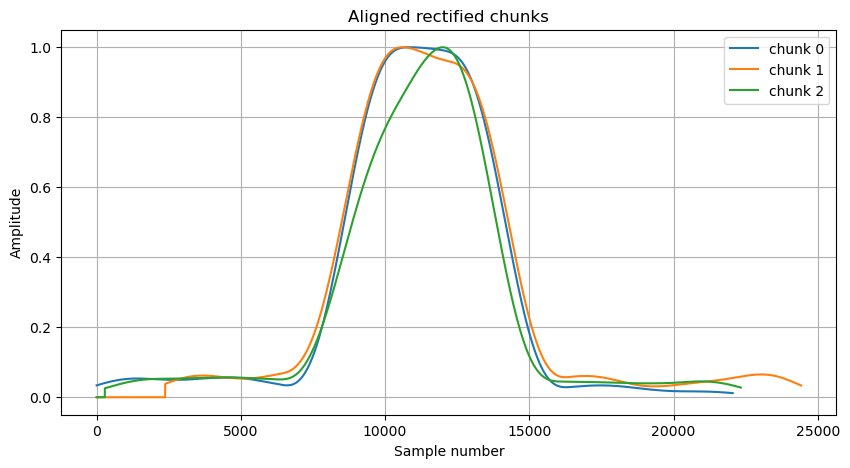

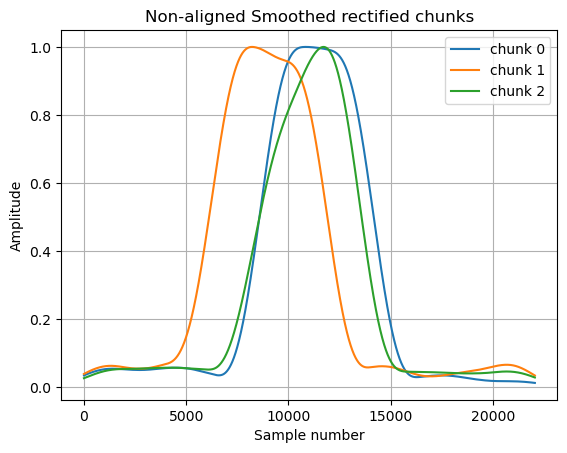

In [14]:
# align the smoothed rectified signals

aligned_smoothed_list = list()

# save the offsets between each signal and the loudest signal to the dictionary
for i, dict_item in enumerate(rec_dict_list):
    dict_item["offset_alignment"] = offset_alignment_array[loudest_signal_index, i]
    print(f'offset between {dict_item["file_name"]} and loudest signal: {dict_item["offset_alignment"]}')

# now visualize our alignments of the smoothed rectified signals
# first zero pad the rectified signals according to the offset alignment
for i, dict_item in enumerate(rec_dict_list):
    if i != loudest_signal_index:    
        print(f'padding {dict_item["file_name"]} with {dict_item["offset_alignment"]} zeros')
        if dict_item["offset_alignment"] > 0:
            aligned_smoothed_list.append( np.pad(smoothed_chunk_list[i], (abs(int(dict_item["offset_alignment"])), 0), 'constant'))
        elif dict_item["offset_alignment"] < 0:
            aligned_smoothed_list.append( np.pad(smoothed_chunk_list[i], (0, abs(int(dict_item["offset_alignment"]))), 'constant'))        
        else:
            aligned_smoothed_list.append(smoothed_chunk_list[i])
    else:
        aligned_smoothed_list.append(smoothed_chunk_list[i])
        print(f'not padding {dict_item["file_name"]}, i={i}, loudest_signal_index={loudest_signal_index}')

# now plot the aligned smoothed rectified signals on top of each other
print(f'plotting rectified aligned chunks')
plt.figure(figsize=(10, 5))
for chunk in aligned_smoothed_list:
    plt.plot(chunk)
plt.title('Aligned rectified chunks')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.legend([f'chunk {i}' for i in range(len(smoothed_chunk_list))])
plt.grid()
plt.show()

# plot the smoothed rectified signal of each chunk on top of each other
for chunk in smoothed_chunk_list:
    plt.plot(chunk)
plt.title('Non-aligned Smoothed rectified chunks')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.grid()
plt.legend([f'chunk {i}' for i in range(len(smoothed_chunk_list))])
plt.show()



# If the above figure (first one) looks aligned then we can start to put the file back together and save it
##  Align (zero pad) the whole raw signals according to the offset alignment
## Don't forget to account for the rough alignment time, as well as the offset alignment

In [15]:
# Now we will use the offset alignment to align the original filtered signals, adding the calculated offset to each signal
# also save the offset alignment to the dictionary for later use

# calculate the rough alignment time in samples
rough_offsets = list()
for dict_item in rec_dict_list:
    rough_align_time_in_samples = int(float(dict_item["rough_align_time"])*dict_item["fs"])
    rough_offsets.append(rough_align_time_in_samples)
max_rough_offset = np.max(rough_offsets)
rough_offsets = [max_rough_offset - offset for offset in rough_offsets] # in samples

#shift all but one signal to the right to account for the rough alignment time, and add the calculated offset
# save the shift_amount to the dictionary for later use
for dict_item, rough_offset in zip(rec_dict_list, rough_offsets):
    print(f'shifting {dict_item["file_name"]} by {(rough_offset/fs)} seconds + {dict_item["offset_alignment"]} samples')    
    if np.isnan(dict_item["offset_alignment"]):
        dict_item["offset_alignment"] = 0   
    shift_amount = int(rough_offset) + int(dict_item["offset_alignment"])
    print(f'shift amount: {shift_amount}')
    dict_item["shift_amount"] = shift_amount
    dict_item["data_wav"] = np.pad(dict_item["data_wav"], (shift_amount, 0), 'constant')
    dict_item["data_wav_len"] = len(dict_item["data_wav"])

# note that the above block of code is destructive, so if you want to run this cell again, you will need to re-run the cell that loads the data
# you also can just save the data to a file at this point as it is all aligned and ready to go

shifting audio_423215500Hz_11-18-36_22-12-2023.wav by 0.0 seconds + nan samples
shift amount: 0
shifting audio_432740000Hz_11-18-40_22-12-2023.wav by 4.0 seconds + 2374.0 samples
shift amount: 178774
shifting audio_458181000Hz_11-19-34_22-12-2023.wav by 58.7 seconds + 283.0 samples
shift amount: 2588953


plotting spectrogram for audio_423215500Hz_11-18-36_22-12-2023.wav


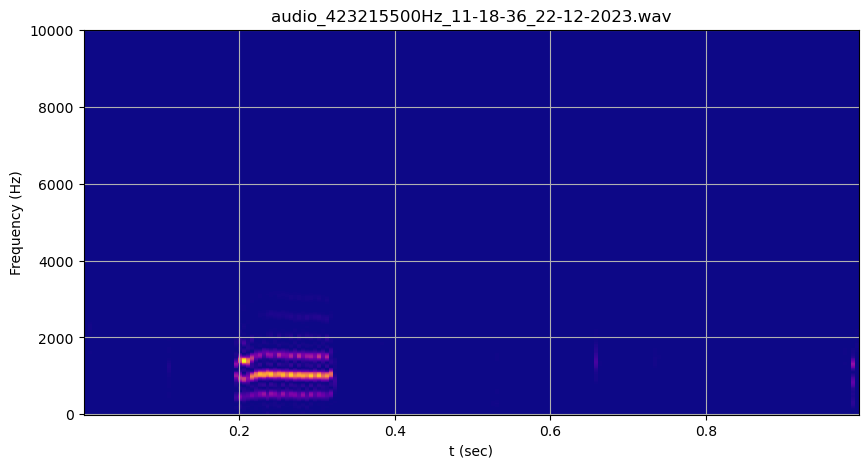

plotting spectrogram for audio_432740000Hz_11-18-40_22-12-2023.wav


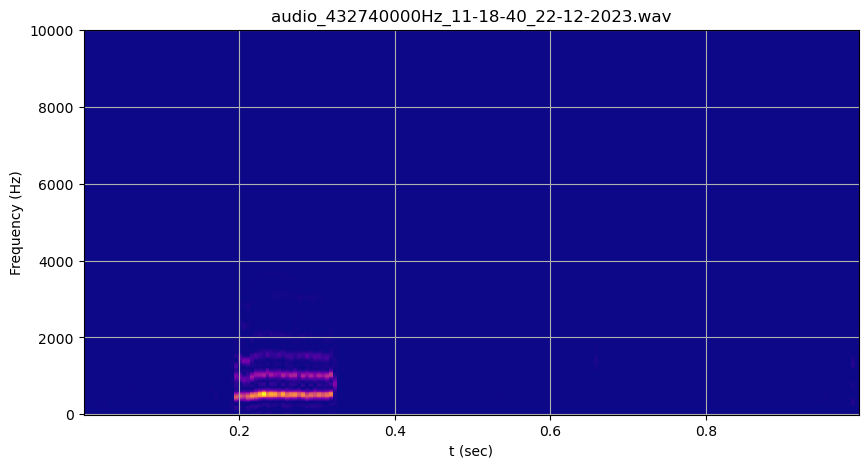

plotting spectrogram for audio_458181000Hz_11-19-34_22-12-2023.wav


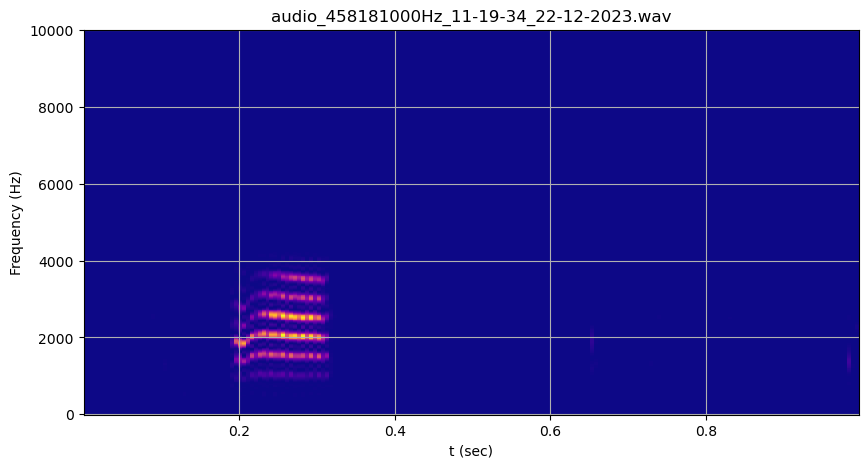

In [21]:
# # at this point, the files should be aligned exactly in time, let's check
len_to_plot = 1
for i, dict_item in enumerate(rec_dict_list):
    start_time = max_rough_offset
    print(f'plotting spectrogram for {dict_item["file_name"]}')
    plot_a_spectrogram(dict_item["data_wav"][start_time:start_time+(len_to_plot*fs)], fs = dict_item["fs"], title=dict_item["file_name"])
    plt.show()  

folder_name: 11-18-36_22-12-2023
/Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/11-18-36_22-12-2023


In [18]:
# # I need to pad the signals to be the same length
# max_len = np.max([dict_item["data_wav_len"] for dict_item in rec_dict_list])
# for i, dict_item in enumerate(rec_dict_list):
#     if dict_item["data_wav_len"] < max_len:
#         dict_item["data_wav"] = np.pad(dict_item["data_wav"], (0, int(max_len - dict_item["data_wav_len"])), 'constant')
#         dict_item["data_wav_len"] = len(dict_item["data_wav"])
#         print(f'padded {dict_item["file_name"]} with {int(max_len - dict_item["data_wav_len"])} zeros')
#         print(f'wav is now {dict_item["data_wav_len"]} long, or {dict_item["data_wav_len"]/fs/60} minutes')
#     else:
#         pass
    
# for dict_item in rec_dict_list:
#     print(len(dict_item["data_wav"]))

In [17]:
# int(max_len - dict_item["data_wav_len"])
dict_item

{'file_name': 'audio_458181000Hz_11-19-34_22-12-2023.wav',
 'rough_align_minute': '67',
 'rough_align_second': '36.8',
 'subject_name': 'WhiWhi1541M',
 'data_wav_unfiltered': array([1308, 1290, 1256, ..., 1184, 1188, 1196], dtype=int16),
 'fs': 44100,
 'data_wav': array([0.        , 0.        , 0.        , ..., 0.00070795, 0.00047364,
        0.0001763 ]),
 'data_wav_len': 445629459,
 'data_wav_len_minutes': 167.4378329554044,
 'rough_align_point': 178904880,
 'rough_align_time': 4056.8,
 'offset_alignment': 283.0,
 'shift_amount': 2588953}

In [18]:
# actually i need to go back to the original unfiltered data and pad/shift it because my dicts were filtered
# and I have to make sure they are all the same length

# left pad I hope to align
for i, dict_item in enumerate(rec_dict_list):
    dict_item["data_wav_unfiltered"] = np.pad(dict_item["data_wav_unfiltered"], (dict_item["shift_amount"], 0), 'constant')
    dict_item["unfiltered_data_wav_len"] = len(dict_item["data_wav_unfiltered"])
    print(f'padded {dict_item["file_name"]} with {dict_item["shift_amount"]} zeros')
    print(f'wav is now {len(dict_item["data_wav_unfiltered"])} long, or {len(dict_item["data_wav_unfiltered"])/fs/60} minutes')

# right pad the unfiltered signals to be the same length
max_len = np.max([dict_item["unfiltered_data_wav_len"] for dict_item in rec_dict_list])
for i, dict_item in enumerate(rec_dict_list):
    if dict_item["unfiltered_data_wav_len"] < max_len:
        dict_item["data_wav_unfiltered"] = np.pad(dict_item["data_wav_unfiltered"], (0, int(max_len - dict_item["unfiltered_data_wav_len"])), 'constant')
        dict_item["unfiltered_data_wav_len"] = len(dict_item["data_wav_unfiltered"])
        print(f'padded {dict_item["file_name"]} with {int(max_len - dict_item["unfiltered_data_wav_len"])} zeros')
        print(f'wav is now {dict_item["unfiltered_data_wav_len"]} long, or {dict_item["unfiltered_data_wav_len"]/fs/60} minutes')
    else:
        pass




# max_len = np.max([dict_item["data_wav_len"] for dict_item in rec_dict_list])
# for i, dict_item in enumerate(rec_dict_list):
#     if dict_item["data_wav_len"] < max_len:
#         dict_item["data_wav_unfiltered"] = np.pad(dict_item["data_wav_unfiltered"], (0, int(max_len - dict_item["data_wav_len"])), 'constant')
#         dict_item["data_wav_len"] = len(dict_item["data_wav_unfiltered"])
#         print(f'padded {dict_item["file_name"]} with {int(max_len - dict_item["data_wav_len"])} zeros')
#         print(f'wav is now {dict_item["data_wav_len"]} long, or {dict_item["data_wav_len"]/fs/60} minutes')
#     else:
#         pass
    


padded audio_423215500Hz_11-18-36_22-12-2023.wav with 0 zeros
wav is now 445492786 long, or 168.36462055933487 minutes
padded audio_432740000Hz_11-18-40_22-12-2023.wav with 178774 zeros
wav is now 445740803 long, or 168.45835336356765 minutes
padded audio_458181000Hz_11-19-34_22-12-2023.wav with 2588953 zeros
wav is now 445629459 long, or 168.41627324263038 minutes
padded audio_423215500Hz_11-18-36_22-12-2023.wav with 0 zeros
wav is now 445740803 long, or 168.45835336356765 minutes
padded audio_458181000Hz_11-19-34_22-12-2023.wav with 0 zeros
wav is now 445740803 long, or 168.45835336356765 minutes


NameError: name 'aligned_data_path' is not defined

In [22]:
# Now save the four aligned signals to four new wav files in a new directory
# Also save the dictionary to a pickle file
# make a new directory to save the aligned wav files

# find all undesrcore indices in the file name
underscore_index = [i for i, ltr in enumerate(rec_1['file_name']) if ltr == '_']
# get the folder name from the file name
folder_name = rec_1['file_name'][underscore_index[1]+1:-4]
print(f'folder_name: {folder_name}')
aligned_data_path = os.path.join(data_path, folder_name)
print(aligned_data_path)
if not os.path.exists(aligned_data_path):
    os.makedirs(aligned_data_path)
    print(f'created directory: {aligned_data_path}')

# save the dictionary to a pickle file
pickle_file_name = os.path.join(aligned_data_path, f'{folder_name}_aligned_dict.pickle')
with open(pickle_file_name, 'wb') as f:
    pickle.dump(rec_dict_list, f)
    print(f'saved dictionary to {pickle_file_name}')

# save the aligned wav files to the new directory
for i, dict_item in enumerate(rec_dict_list):
    write(os.path.join(aligned_data_path, dict_item["file_name"]), fs, dict_item["data_wav_unfiltered"])
    print(f'saved {dict_item["file_name"]} to {aligned_data_path}') 

# # save the dictionary to a pickle file
# pickle_file_name = os.path.join(aligned_data_path, f'{folder_name}_aligned_dict.pickle')
# with open(pickle_file_name, 'wb') as f:
#     pickle.dump(rec_dict_list, f)
#     print(f'saved dictionary to {pickle_file_name}')
    


folder_name: 11-18-36_22-12-2023
/Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/11-18-36_22-12-2023
created directory: /Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/11-18-36_22-12-2023
saved dictionary to /Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/11-18-36_22-12-2023/11-18-36_22-12-2023_aligned_dict.pickle
saved audio_423215500Hz_11-18-36_22-12-2023.wav to /Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/backup/11-18-36_22-12-2023
saved audio_432740000Hz_11-18-40_22-12-2023.wav to /Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_22_23__11_18/bac

In [20]:
folder_name

NameError: name 'folder_name' is not defined

In [19]:
# our wav files that I save aren't able to be opened in some programs, so I'm going to save them as 16 bit ints
# these are actually already filtered but that's ok because I'm going to just use them as a quick reference in Raven

# first normalize the signals
for dict_item in rec_dict_list:
    dict_item["data_wav"] = dict_item["data_wav"] / np.max(np.abs(dict_item["data_wav"]))
    dict_item["data_wav"] = dict_item["data_wav"] * 32767
    dict_item["data_wav"] = dict_item["data_wav"].astype(np.int16)



# check if the directory exists
aligned_data_path = os.path.join(data_path, folder_name)
if not os.path.exists(aligned_data_path):
    os.makedirs(aligned_data_path)

# save the wav files as an n channel single file
# first stack the data
data_wav_stacked = np.vstack((dict_item["data_wav"] for dict_item in rec_dict_list)).T
# now save the wav file
write(os.path.join(aligned_data_path, 'aligned_data.wav'), fs, data_wav_stacked)

# now save the unfiltered wav files
for dict_item in rec_dict_list:
    write(os.path.join(aligned_data_path, dict_item["file_name"]), dict_item["fs"], dict_item["data_wav_unfiltered"])


# for dict_item in rec_dict_list:
#     write(os.path.join(aligned_data_path, dict_item["file_name"]), dict_item["fs"], dict_item["data_wav"])

# save the dictionary
with open(os.path.join(aligned_data_path, 'rec_dict_list.pickle'), 'wb') as f:
    pickle.dump(rec_dict_list, f)


NameError: name 'aligned_data_path' is not defined

In [ ]:
# # Make the new directory
# os.mkdir(aligned_data_path)

# # save the aligned wav files
# for i, dict_item in enumerate(rec_dict_list):
#     print(f'saving aligned wav file: {dict_item["file_name"]}')
#     write(os.path.join(aligned_data_path, dict_item["file_name"]), dict_item["fs"], dict_item["data_wav"])  

# # save the dictionary
# print(f'saving dictionary to pickle file')
# with open(os.path.join(aligned_data_path, 'rec_dict_list.pickle'), 'wb') as f:
#     pickle.dump(rec_dict_list, f)

# print(f'Done saving aligned wav files and dictionary to pickle file.')

FileExistsError: [Errno 17] File exists: '/Users/williamwood/Documents/Data/Field Station Recordings/December 2023 Recordings Field Station/Aligned_For_SoundSep/12_20_23__9_51/09-51-40_20-12-2023'

In [ ]:
# #print the length of each signal in data points
# for i, dict_item in enumerate(rec_dict_list):
#     print(f'{dict_item["file_name"]} length: {dict_item["data_wav_len"]}, data points len: {len(dict_item["data_wav"])}')


In [ ]:
# # an attempt to see if the alignment is good, might be better just to open these in Audacity or Raven

# # plot the beginning of the aligned signals
# for i, dict_item in enumerate(rec_dict_list):
#     plt.plot(dict_item["data_wav"][:1000])
# plt.title('Aligned raw chunks')
# plt.xlabel('Sample number')
# plt.ylabel('Amplitude')
# plt.grid()
# plt.legend([f'chunk {i}' for i in range(len(smoothed_chunk_list))])
# plt.show()

# # plot the end of the aligned signals
# for i, dict_item in enumerate(rec_dict_list):
#     plt.plot(dict_item["data_wav"][-1000:])
# plt.title('Aligned raw chunks')
# plt.xlabel('Sample number')
# plt.ylabel('Amplitude')
# plt.grid()
# plt.legend([f'chunk {i}' for i in range(len(smoothed_chunk_list))])
# plt.show()

# # plot 1000 samples of the aligned signals at the rough alignment time + 1 s
# for i, dict_item in enumerate(rec_dict_list):
#     plt.plot(dict_item["data_wav"][int(float(dict_item["rough_align_time"])*dict_item["fs"])+int(dict_item["fs"]):int(float(dict_item["rough_align_time"])*dict_item["fs"])+int(dict_item["fs"])+1000])
# plt.title('Aligned raw chunks')
# plt.xlabel('Sample number')
# plt.ylabel('Amplitude')
# plt.grid()
# plt.legend([f'chunk {i}' for i in range(len(smoothed_chunk_list))])
# plt.show()

